# Update 2022.03.08
Modified typo

# Intro

This is a NOTEBOOK for achieving a score of **0.0226**, but the content itself is simply a fusion of Byfone and Chris' methods.
- Byfone: https://www.kaggle.com/byfone/h-m-trending-products-weekly
- Chris : https://www.kaggle.com/cdeotte/recommend-items-purchased-together-0-021  

I learned Byfone's unique way of thinking while creating this notebook, and I would like to include an explanation of it as a memo.
(I hope I am interpreting byfone's algo correctly😂)

# Agenda
 - Byfone approach overview
 - Chris approach overview
 - Byfone&Chris combination approach
 - Score **0.0226** code
 
## If you think you can upvote for this notebook, please upvote for byfone and chris's notebook as well (and of course you can upvote for me too 😁

# Byfone approach
https://www.kaggle.com/byfone/h-m-trending-products-weekly


## Quotient variable
Byfone creates a variable called **quotient** by aggregation and makes the top12 of the sum of the quotients to create the **general_pred** variable.  
The score drops to around **0.0225** to **0.0223** when simply taking the top12 sales units in September instead of the general_pred variable, which proves the validity of this approach.  

**quotient** is a variable that is the quotient of the number of units sold in the week of 9/22 and the number of units sold in each week for a given article_id.

### For example article_id: **0573085028**
A total of **370** units of this article were sold during the week of **2020-09-22**. A total of **160** units were sold during the week of **2018-09-25**.
Then **quotient** is calculated as **2.3125** for this transaction idx 1346.

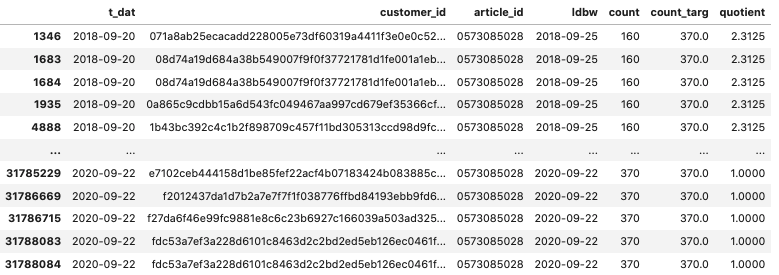

The variable Quotient is characterized by
1. if sales units in the week of 2020-09-22 are higher than sales in the week before 2020-09-22, the value will be larger, which is an indicator of the growth rate.
2. Quotient is calculated for all transactions. Thus, the "sum of quotients" is an indicator that has a larger value when the number of units sold is higher, and an indicator that has a larger value when there is a high growth rate. 


## Recommending to customers products they have already purchased before
Byfone has also adopted the strategy of proposing the same article again.  

The indicator for whether or not customer A will purchase product B again is generated by following code.

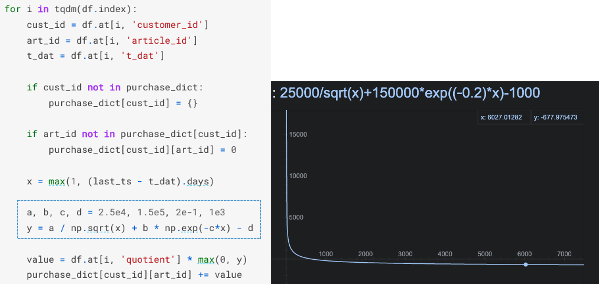

x: number of days elapsed from the date Customer A purchased Product B to 2020-09-22  
y: Value to be decayed by the x  (**★Customers purchase the same product within a short period of time**)  
(This is true! Please see https://www.kaggle.com/lichtlab/do-customers-buy-the-same-products-again)    


value: y * qutient (If a customer buys the same product for a short period of time, and if the growth rate of that product is high, it is expected that they will buy more.)

taking the date when customer X purchased product Y as the peak, generating a value to be decayed by the number of days elapsed from that date until 2020-09-20, and multiplying this value by the growth rate of the product itself.

# Chris approach
https://www.kaggle.com/cdeotte/recommend-items-purchased-together-0-021

Chris' approach was well-explained by his notebook. So let me skip here.

# Byfone&Chris combination approach

The approach is to 

1. First determine the products to be recommended byfone's algorithm, 
2. Then recommend the products that would be bought in pairs by chris' algorithm, 
3. Finally recommend additional top12 products as defined byfone's sum of quotinet (**general_pred**)


# Score **0.0226** code

In [ ]:
import pandas as pd
import numpy as np
from math import sqrt
from pathlib import Path
from tqdm import tqdm
tqdm.pandas()

N = 12
df_trans = pd.read_csv('/kaggle/input/h-and-m-personalized-fashion-recommendations/transactions_train.csv',dtype={'article_id': str})
df_trans['t_dat'] = pd.to_datetime(df_trans['t_dat'])


In [ ]:
# Step1
df = df_trans[['t_dat', 'customer_id', 'article_id']].copy()
last_ts = df['t_dat'].max()
df['ldbw'] = df['t_dat'].apply(lambda d: last_ts - (last_ts - d).floor('7D'))
weekly_sales = df.drop('customer_id', axis=1).groupby(['ldbw', 'article_id']).count()
weekly_sales = weekly_sales.rename(columns={'t_dat': 'count'})
df = df.join(weekly_sales, on=['ldbw', 'article_id'])
weekly_sales = weekly_sales.reset_index().set_index('article_id')
last_day = last_ts.strftime('%Y-%m-%d')

df = df.join(
    weekly_sales.loc[weekly_sales['ldbw']==last_day, ['count']],
    on='article_id', rsuffix="_targ")

df['count_targ'].fillna(0, inplace=True)
del weekly_sales
df['quotient'] = df['count_targ'] / df['count']

purchase_dict = {}

for i in tqdm(df.index):
    cust_id = df.at[i, 'customer_id']
    art_id = df.at[i, 'article_id']
    t_dat = df.at[i, 't_dat']

    if cust_id not in purchase_dict:
        purchase_dict[cust_id] = {}

    if art_id not in purchase_dict[cust_id]:
        purchase_dict[cust_id][art_id] = 0
    
    x = max(1, (last_ts - t_dat).days)

    a, b, c, d = 2.5e4, 1.5e5, 2e-1, 1e3
    y = a / np.sqrt(x) + b * np.exp(-c*x) - d

    value = df.at[i, 'quotient'] * max(0, y)
    purchase_dict[cust_id][art_id] += value

target_sales = df.drop('customer_id', axis=1).groupby('article_id')['quotient'].sum()
general_pred = target_sales.nlargest(N).index.tolist()

In [ ]:
# Step2 & Step3
pairs = np.load('../input/hmitempairs/pairs_cudf.npy',allow_pickle=True).item()
sub = pd.read_csv('/kaggle/input/h-and-m-personalized-fashion-recommendations/sample_submission.csv')

pred_list = []
for cust_id in tqdm(sub['customer_id']):
    if cust_id in purchase_dict:
        series = pd.Series(purchase_dict[cust_id])
        series = series[series > 0]
        l = series.nlargest(N).index.tolist()
        tmp_l = l.copy()
        for elm in tmp_l:
            if len(l) < N and int(elm) in pairs.keys():
                itm = pairs[int(elm)]
                l.append('0' + str(itm))
        if len(l) < N:
            l = l + general_pred[:(N-len(l))]
    else:
        l = general_pred
    pred_list.append(' '.join(l))

sub['prediction'] = pred_list
sub.to_csv(f'submission.csv',index=False)
